In [103]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pytensor
from scipy.optimize import least_squares
import math
from photonic_hamiltonian.inference import io_data
#load an example data file, data courtersy: Fan Du
real_data = io_data.load_data('photonic_hamiltonian\data\expdata_singleKspectrum.nc')

In [107]:
from pytensor import tensor as pt
import numpy as np
import pymc as pm
import pytensor

def Hamiltonian_model(data,prior_bounds):
    """
    returns a pymc model to infer the parameters for a four-basis Hamiltonian.
    The piors on all parameters ~ Uniform(given lower, given upper)
    The likelihood ~ Gaussian(line, sigma_y)
    Line is the expectation value obtained by taking the sum of background and 4 Gaussian peaked
    at the eigenvalues of 4x4 Hamiltonian matrix
    
    Parameters:
        data: the data set of a single-momentum spectrum 
              (DataArray with 'x': frequency, 'y': intensity, and 'sigma_y': intensity uncertainty)
        prior_bounds: the bounds for uniform priors of all parameters we want to infer
              (dict mapping a string, name of the parameter, to a list of its bounds [lower, upper])
              
    Return:
        ham_model: the pymc model can be used to infer the parameters and their posterior
              (pymc Model object)
    
    """
    #extract data to numpy arrays
    freq = data['normf'].to_numpy()
    intensity = data['spectrum'].to_numpy()
    intensity_sig = data['spectrum_std'].to_numpy()
    kx = 0.05
    ky = 0
    #define likelihood function
    def likelihood(theta, y, x, sigma_y):
        """
        returns the loglike likelihood of our model
        
        Parameters:
            theta: the parameters in Hamiltonian matrix (list)
            y, x, sigma_y: our data (numpy arrays)
        
        Return:
            the loglike likelihood (float)
        """
        #for our four-basis Hamiltonian, the parameters include
        #interaction-between-modes terms u11, u20;
        #background A0 and heights of 4 peaks A1, A2, A3, A4
        #peak width (assumed to be the same for all peaks) sigma_L
        u11, u20, neff, ratio, A0, A1, A2, A3, A4, W1, W2, W3, W4 = theta
        neff = 2.122
        ratio = 0.211
        ham = pytensor.shared(np.zeros((4,4)))
        #energy of each mode is assumed to be fixed
        Gx = np.array((0.0,1.0,0.0,-1.0))
        Gy = np.array((1.0,0.0,-1.0,0.0))
        kxin = kx-Gx*np.sqrt(2)/2+Gy*np.sqrt(2)/2
        kyin = ky-Gx*np.sqrt(2)/2-Gy*np.sqrt(2)/2
        for i in range(4):
            k = np.sqrt(Gx[i]**2+Gy[i]**2)
            k0 = np.linspace(0.5,1,100000)
            k0 = pytensor.shared(k0)
            res = pt.abs(pt.sqr(neff)*pt.sqrt(pt.sqr(k)- pt.sqr(k0)) -  \
                         pt.sqrt( pt.sqr(neff)*pt.sqr(k0)-pt.sqr(k))* pt.tan(pt.sqrt(pt.sqr(neff)*pt.sqr(k0)-pt.sqr(k))*2*np.pi*ratio))
            
            min_index = pt.argmin(res)
#             min_k0 = k0[min_index]
#             res = torch.abs(neff**2*torch.sqrt( k**2-k0**2 )-torch.sqrt( (neff**2)*(k0)**2-k**2 ) * torch.tan(torch.sqrt( (neff**2)*(k0)**2-k**2 )*2*pi*ratio)) 
#             min_index = torch.argmin(res)
            eigen_k0 = k0[min_index]
            print(eigen_k0)
            pt.set_subtensor(ham[i, i], eigen_k0)
            #ex = 0.669   # for k = (0, +-0.05) the energy of uncoupled slab mode 1 
            #ey = 0.6346    # for k = (+-0.05,0) the energy of uncoupled slab mode 2
        
        #Hamiltonian matrix
        ham_np = np.array([[0,u11,u20,u11],
                           [u11,0,u11,u20],
                           [u20,u11,0,u11],
                           [u11,u20,u11,0]])
        
        for row in range(4):
            for col in range(4):
                if row != col:
                    ham = pt.set_subtensor(ham[row, col], ham_np[row, col])
        
        #peak heights and peak positions
        An_np = np.array([A1,A2,A3,A4])
        An = pytensor.shared(np.zeros(4))
        Wn_np = np.array([W1, W2, W3, W4])
        Wn = pytensor.shared(np.zeros(4))
        for col in range(4):
            An = pt.set_subtensor(An[col], An_np[col])
            Wn = pt.set_subtensor(Wn[col], Wn_np[col])

        Cn = pt.nlinalg.eigh(ham)[0]
        # make sure eigenvalues are sorted
        Cn = pt.sort(Cn)
        shift = 0.003
        ratioA = 0.25
        ratio = 0.9
        #expectation value as sum of 4 gaussian peaks and background
        #line = A0 + An[0] * pt.exp(-pt.sqr(x - Cn[0]) / (2 * pt.sqr(sigma_L))) + An[1] * pt.exp(-pt.sqr(x - Cn[1]) / (2 * pt.sqr(sigma_L))) + An[2] * pt.exp(-pt.sqr(x - Cn[2]) / (2 * pt.sqr(sigma_L))) + An[3] * pt.exp(-pt.sqr(x - Cn[3]) / (2 * pt.sqr(sigma_L)))
        #### lorentz = [(Ai * sigma_n**2)/((f - Ci)**2 + sigma_n**2) for Ai, Ci, sigma_n in zip(An, Cn,sigma_n)]
        line0 = An[0]*pt.sqr(Wn[0])/(pt.sqr(x-Cn[0])+pt.sqr(Wn[0])) + An[1]*pt.sqr(Wn[1])/(pt.sqr(x - Cn[1])+pt.sqr(Wn[1])) + An[2]*pt.sqr(Wn[2])/(pt.sqr(x - Cn[2])+pt.sqr(Wn[2]))+An[3]*pt.sqr(Wn[3])/(pt.sqr(x - Cn[3])+pt.sqr(Wn[3]))
        line1 = ratioA*(An[0]*pt.sqr(Wn[0]*ratio)/(pt.sqr(x-Cn[0]-shift)+pt.sqr(Wn[0]*ratio)) + \
                       An[1]*pt.sqr(Wn[1]*ratio)/(pt.sqr(x - Cn[1]-shift)+pt.sqr(Wn[1]*ratio)) + \
                       An[2]*pt.sqr(Wn[2]*ratio)/(pt.sqr(x - Cn[2]-shift)+pt.sqr(Wn[2]*ratio))+\
                       An[3]*pt.sqr(Wn[3]*ratio)/(pt.sqr(x - Cn[3]-shift)+pt.sqr(Wn[3]*ratio)))
        line2 = ratioA*(An[0]*pt.sqr(Wn[0]*ratio)/(pt.sqr(x-Cn[0]+shift)+pt.sqr(Wn[0]*ratio)) + \
                       An[1]*pt.sqr(Wn[1]*ratio)/(pt.sqr(x - Cn[1]+shift)+pt.sqr(Wn[1]*ratio)) + \
                       An[2]*pt.sqr(Wn[2]*ratio)/(pt.sqr(x - Cn[2]+shift)+pt.sqr(Wn[2]*ratio))+\
                       An[3]*pt.sqr(Wn[3]*ratio)/(pt.sqr(x - Cn[3]+shift)+pt.sqr(Wn[3]*ratio)))
        line = A0+line0
        return pt.sum(-(0.5 / pt.sqr(sigma_y)) * pt.sqr(y - line))
    
    #create the multi Gaussian peak model
    ham_model = pm.Model()
    with ham_model:
        # Priors for unknown model parameters
        theta_list = []
        for i in list(prior_bounds.keys()):
            #check if the lower bound is strictly smaller than the upper bound
            if prior_bounds[i][0] >= prior_bounds[i][1]:
                raise ValueError
            theta_list.append(pm.Uniform(i, lower=prior_bounds[i][0], upper=prior_bounds[i][1]))
    
        #input of our log-likelihood
        theta = pt.as_tensor_variable(theta_list)
    
        # Likelihood of observations
        pm.Potential("likelihood", likelihood(theta,intensity, freq, intensity_sig))

    return ham_model

def fit_curve(freq, theta):
    """
    Calculate the multi Gaussian peak curve fit using a set of given fitting parameters

    Parameters
    ----------
    freq (NumPy array):
        The array of normalized frequency (x data)
    theta (list):
        The list of fitting parameters, in the order u11, u20, A0, A1, A2, A3, A4, sigma_L
        
    Return
    ---------
    line (NumPy array):
        The array of corresponding fitted intensity
    """
    ex = 0.67245835   # for k = (0, +-0.05) the energy of uncoupled slab mode 1 
    ey = 0.64362236   # for k = (+-0.05,0) the energy of uncoupled slab mode 2
    u11, u20, A0, A1, A2, A3, A4, W1, W2, W3, W4 = theta
    An = [A1, A2, A3, A4]
    Wn = [W1, W2, W3, W4]
    shift = 0.003
    ratio = 0.25
    ratiow = 0.9
    Aside = [A1*ratio,A2*ratio,A3*ratio,A4*ratio]
    Wside = [W1*ratiow,W2*ratiow,W3*ratiow,W4*ratiow]
    #Hamiltonian matrix and its eigenvalues as line peaks
    H = [[ex,u11,u20,u11],
         [u11,ey,u11,u20],
         [u20,u11,ey,u11],
         [u11,u20,u11,ex]]
    Cn = np.real(np.linalg.eigvals(H))
    Cn = np.sort(Cn)
    
    #calculate normalized intensity
    line0 = [(Ai * Wi**2)/((freq- Ci)**2 + Wi**2) for Ai, Ci, Wi in zip(An, Cn, Wn)]
    line1 =  [(Ai * Wi**2)/((freq- Ci)**2 + Wi**2) for Ai, Ci, Wi in zip(Aside, Cn-shift, Wside)]
    line2 =  [(Ai * Wi**2)/((freq- Ci)**2 + Wi**2) for Ai, Ci, Wi in zip(Aside, Cn+shift, Wside)]
    line = line0
    #line_each = [Ai * np.exp(-(freq - Ci)**2 / (2 * sigma_L**2)) for Ai, Ci in zip(An, Cn)]
    line = np.sum(line, axis=0) + A0
    
    return line

Text(0.5, 1.0, 'Simulated data showing four energy bands of a single C4-symmetric photonic crystal')

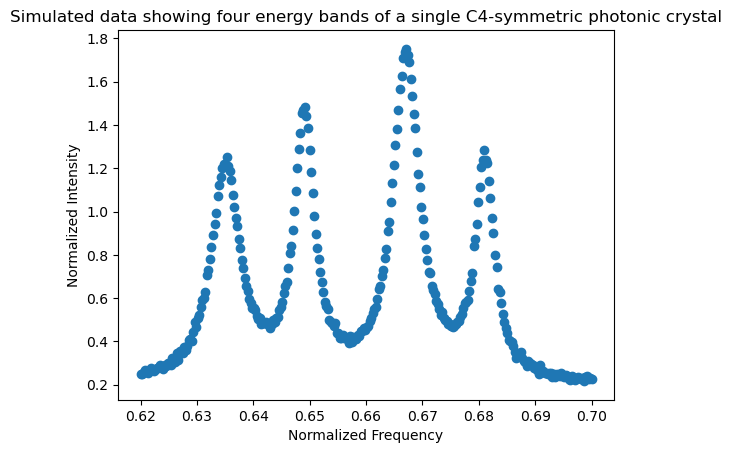

In [91]:
# Create simulated data
N = 300
simu_normf = np.linspace(0.62,0.70,N)    # create normalized frequency, "x" variable 

#set all hamiltonian parameters as some constants
u11 = 0.007
u20 = 1e-5
A0 = 0.2
A1 = 1
A2 = 1.2
A3 = 1.5
A4 = 1
[A1,A2,A3,A4] = [1,1.2,1.5,1]
#sigma_L = 0.002
[W1,W2,W3,W4] = [0.003,0.0021,0.0028,0.002]
theta = [u11, u20, A0, A1, A2, A3, A4, W1,W2,W3,W4]

#create normalized intensity
line = fit_curve(simu_normf, theta)

#create noise
sigma_noise = 0.01
noise = np.random.normal(0, sigma_noise, N)

#create data array
simu_data = xr.Dataset(data_vars = {'spectrum': ('normf', line + noise),
                                  'spectrum_std': ('normf', [sigma_noise]*N)},
                     coords = { 'normf': simu_normf})

#plot the simulated data to visualize the four peaks
plt.errorbar(simu_normf, line + noise, sigma_noise, fmt='o')
plt.xlabel('Normalized Frequency')
plt.ylabel('Normalized Intensity')
plt.title('Simulated data showing four energy bands of a single C4-symmetric photonic crystal')

Only 300 samples in chain.


Subtensor{int64}.0
Subtensor{int64}.0
Subtensor{int64}.0
Subtensor{int64}.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u11, u20, neff, ratio, A0, A1, A2, A3, A4, W1, W2, W3, W4]


Sampling 4 chains for 10 tune and 300 draw iterations (40 + 1_200 draws total) took 114 seconds.


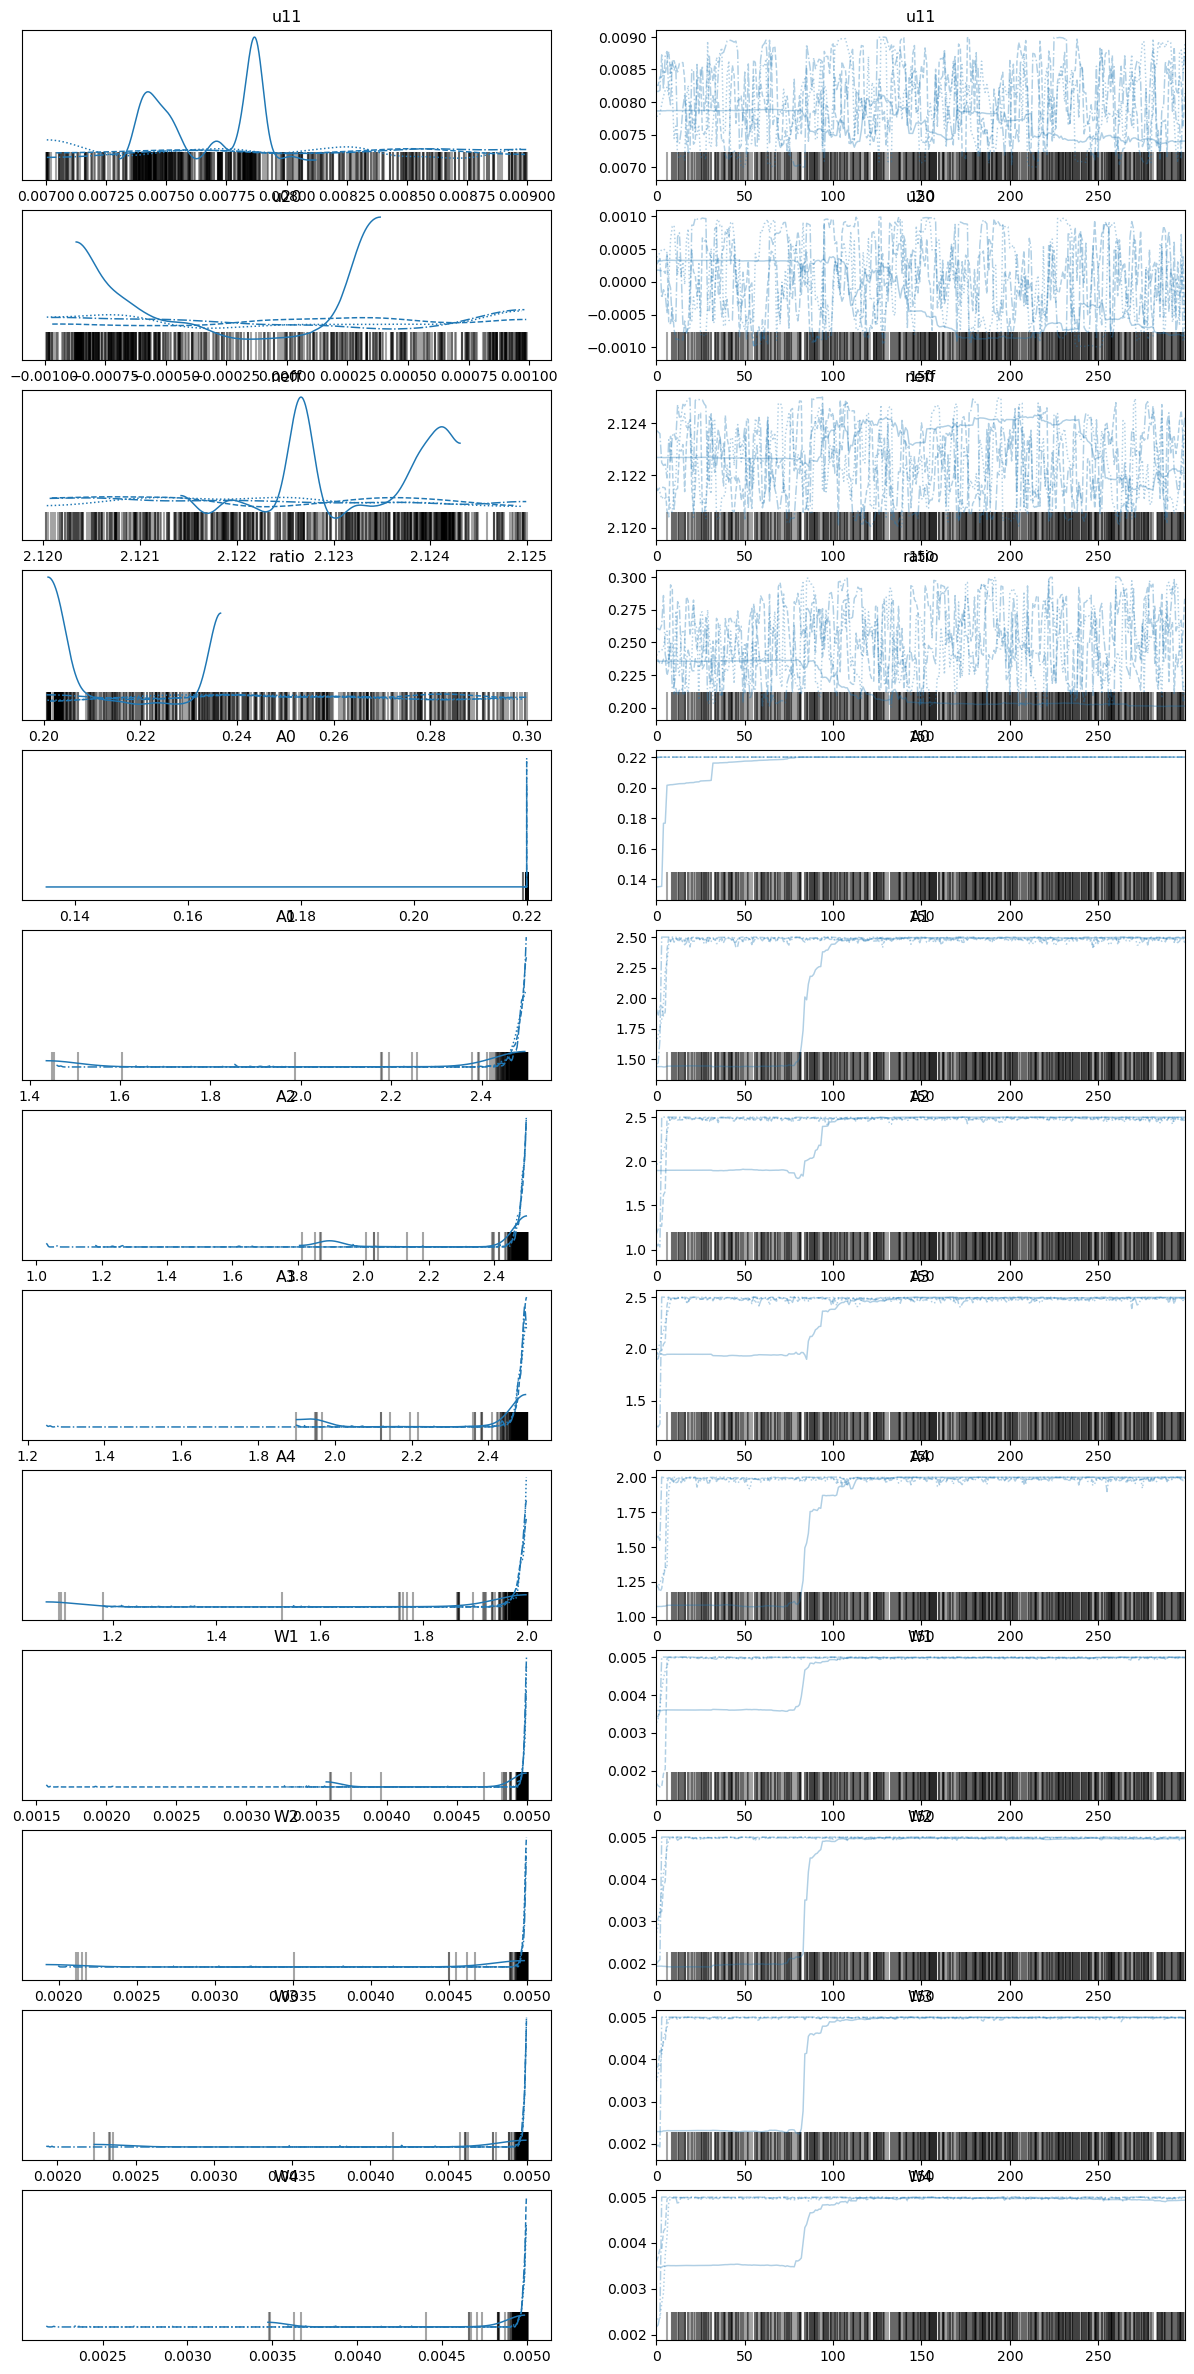

In [110]:
#guess the prior bounds
prior_W = [0.0005,0.005]
simu_prior_bounds = {'u11':[0.007, 0.009], 'u20':[-0.001, 0.001], 'neff':[2.12,2.125],'ratio':[0.2,0.3],
                     'A0':[0.1, 0.22], 'A1':[0.5, 2.5],'A2':[0.5, 2.5], 'A3':[0.5, 2.5], 'A4':[0.5, 2,5],
                     'W1':prior_W, 'W2':prior_W, 'W3':prior_W, 'W4':prior_W}

#create the model 
simu_ham_model = Hamiltonian_model(simu_data, simu_prior_bounds)
with simu_ham_model:
    simu_idata = pm.sample(300, tune=10)

az.plot_trace(simu_idata, figsize=(15,30));

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
u11,0.007919,0.000523,0.007001,0.008833,0.000067,0.000049,112.872747,268.530612,1.159776
u20,-0.000055,0.000582,-0.000871,0.000964,0.000112,0.000080,36.908120,183.322954,1.102160
neff,2.122608,0.001321,2.120168,2.124586,0.000123,0.000087,147.912402,266.865194,1.121283
ratio,0.241012,0.029071,0.200634,0.290864,0.008249,0.005976,10.411073,20.244440,1.313058
A0,0.219183,0.005740,0.218442,0.220000,0.001094,0.000838,11.482815,11.583438,1.311755
A1,2.401585,0.275210,1.445401,2.499997,0.097734,0.071966,15.375556,11.882264,1.190486
A2,2.430490,0.189532,1.899236,2.499998,0.058739,0.045059,13.431690,16.385241,1.213631
A3,2.435967,0.159959,1.948409,2.499408,0.055041,0.041395,14.222117,18.504708,1.210533
A4,1.913905,0.242782,1.085281,1.999985,0.086530,0.063900,10.940147,11.869101,1.290948
W1,0.004862,0.000428,0.003609,0.005000,0.000126,0.000097,20.671055,18.606968,1.145156


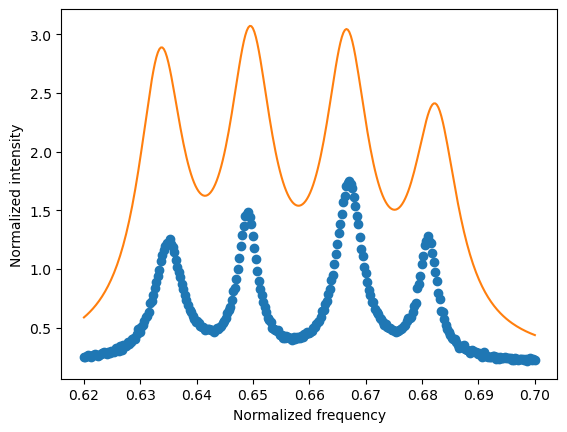

In [111]:
#summary the fitting results
simu_summary = az.summary(simu_idata,round_to=8)
display(simu_summary)

#plot data with the fitting curve
u11, u20,neff,ratio, A0, A1, A2, A3, A4, W1,W2,W3,W4 = simu_summary['mean'].values
simu_theta = [u11, u20, A0, A1, A2, A3, A4, W1,W2,W3,W4]
model_predictions = fit_curve(simu_normf, simu_theta)
plt.xlabel("Normalized frequency")
plt.ylabel("Normalized intensity")
plt.errorbar(simu_normf, line + noise, sigma_noise, fmt = 'o')
plt.plot(simu_normf, model_predictions);

Text(0.5, 1.0, 'Example data showing four energy bands of a single C4-symmetric photonic crystal')

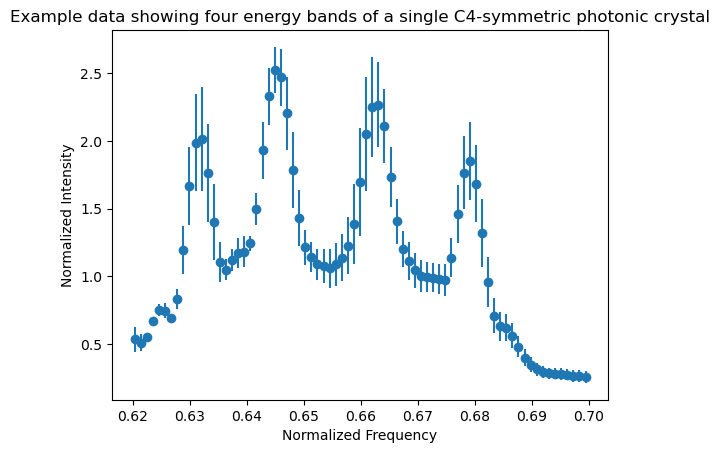

In [104]:
freq = real_data['normf'].to_numpy()
intensity = real_data['spectrum'].to_numpy()
intensity_sig = real_data['spectrum_std'].to_numpy()
plt.errorbar(freq, intensity, intensity_sig,fmt='o')
plt.xlabel('Normalized Frequency')
plt.ylabel('Normalized Intensity')
plt.title('Example data showing four energy bands of a single C4-symmetric photonic crystal')

Subtensor{int64}.0
Subtensor{int64}.0
Subtensor{int64}.0
Subtensor{int64}.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u11, u20, neff, ratio, A0, A1, A2, A3, A4, W1, W2, W3, W4]


Sampling 4 chains for 10 tune and 500 draw iterations (40 + 2_000 draws total) took 145 seconds.


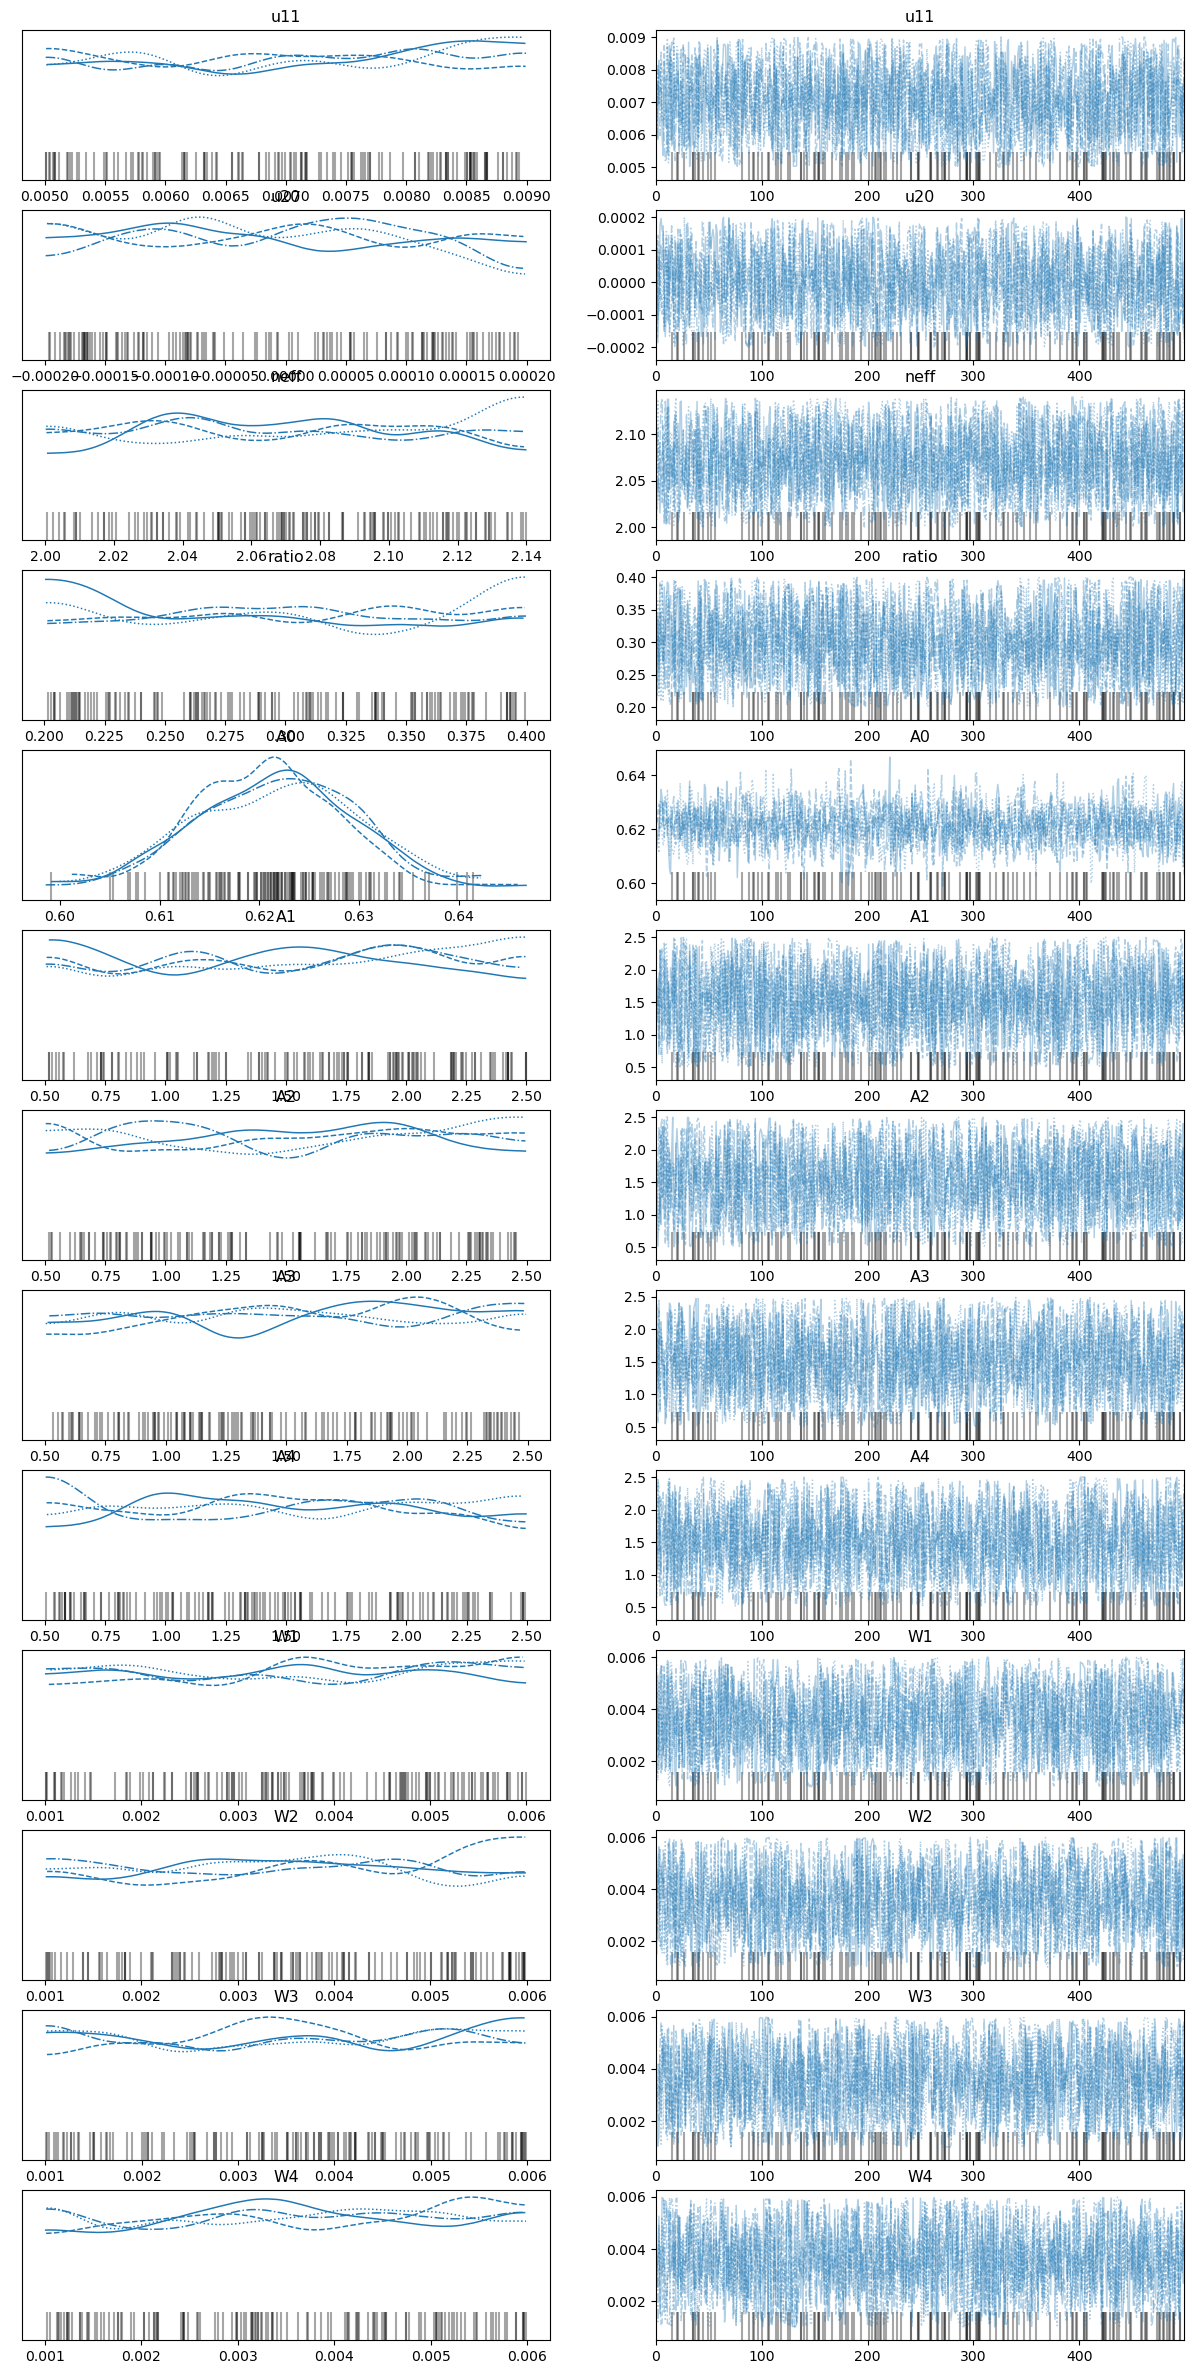

In [108]:
#guess the prior bounds
# u11, u20, neff, ratio, A0, A1, A2, A3, A4, W1, W2, W3, W4 = theta
prior_W = [0.001,0.006]
deltah =1e-4
simu_prior_bounds = {'u11':[0.005, 0.009], 'u20':[-0.0002, 0.0002], 'neff':[2.,2.14],'ratio':[0.2,0.4],
                     'A0':[0, 1], 'A1':[0.5, 2.5],'A2':[0.5, 2.5], 'A3':[0.5, 2.5], 'A4':[0.5, 2.5],
                     'W1':prior_W, 'W2':prior_W, 'W3':prior_W, 'W4':prior_W}

#create the model 
simu_ham_model = Hamiltonian_model(real_data,simu_prior_bounds)
with simu_ham_model:
    simu_idata = pm.sample(500, tune=10)

az.plot_trace(simu_idata, figsize=(15,30));

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
u11,0.007039,0.001167,0.005171,0.008929,0.000025,0.000018,1988.621493,1214.648603,1.002165
u20,-0.000004,0.000113,-0.000199,0.000168,0.000002,0.000003,1972.374694,1240.875917,1.000765
neff,2.070261,0.040067,2.005496,2.135884,0.000823,0.000582,2446.841773,1264.910869,1.009477
ratio,0.299604,0.058575,0.208603,0.396151,0.001332,0.000959,1718.187250,1151.322132,1.002024
A0,0.621438,0.007638,0.607712,0.635506,0.000178,0.000126,1836.694269,1470.242284,1.004197
A1,1.516612,0.575757,0.545252,2.424907,0.012410,0.009080,2092.614297,1069.079829,1.001282
A2,1.512680,0.578375,0.512331,2.375621,0.012179,0.008842,2205.820238,1297.182132,1.007076
A3,1.510682,0.567522,0.626269,2.477903,0.011267,0.008115,2388.315290,1285.025842,0.999322
A4,1.493766,0.569851,0.515283,2.369569,0.011951,0.008717,2020.658479,1074.574194,1.001910
W1,0.003536,0.001446,0.001238,0.005901,0.000031,0.000023,1661.860352,888.195800,1.000163


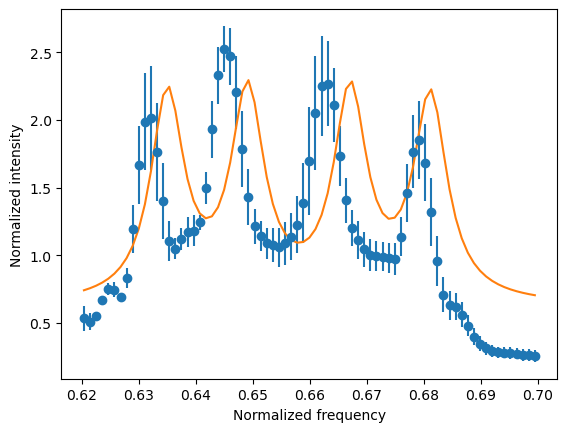

In [109]:
#summary the fitting results
summary = az.summary(simu_idata,round_to=8)
display(summary)

#plot data with the fitting curve
# u11, u20, neff,ratio, A0, A1, A2, A3, A4, W1,W2,W3,W4 = simu_summary['mean'].values
# simu_theta = [u11, u20,neff,ratio, A0, A1, A2, A3, A4, W1,W2,W3,W4]
# model_predictions = fit_curve(freq, theta)
# plt.xlabel("Normalized frequency")
# plt.ylabel("Normalized intensity")
# plt.errorbar(freq, intensity, intensity_sig, fmt = 'o')
# plt.plot(freq, model_predictions);

#plot data with the fitting curve
u11, u20, neff,ratio, A0, A1, A2, A3, A4, W1,W2,W3,W4 =summary['mean'].values
theta = [u11, u20, A0, A1, A2, A3, A4, W1,W2,W3,W4]
model_predictions = fit_curve(freq, theta)
plt.xlabel("Normalized frequency")
plt.ylabel("Normalized intensity")
plt.errorbar(freq, intensity, intensity_sig, fmt = 'o')
plt.plot(freq, model_predictions);

## py tensor solve nonliear function 

In [30]:
def slabmode2(kx, ky, neff=1.573, ratio=0.3): ### The authentic waveguide mode, TM0 mode
    ###ratio = thickness/lattice constant
    k=np.sqrt(kx**2+ky**2)
    def func(k0):
        return neff**2*np.sqrt( k**2-k0**2 ) -  np.sqrt( (neff**2)*(k0)**2-k**2 ) * np.tan(np.sqrt( (neff**2)*(k0)**2-k**2 )*2*np.pi*ratio)
#     result = fsolve(func, k/neff+0.1)
    
    res = least_squares(func, (k/neff+0.000001), bounds = (k/neff,k))
    return res.x[0]
# def slabmode(kx, ky, neff=1.573, ratio=0.3): ### The authentic waveguide mode, TM0 mode
#     ###ratio = thickness/lattice constant
#     k=pt.sqrt(pt.sqr(kx)+pt.sqr(ky))
#     def func(k0):
#         return pt.sqr(neff)*pt.sqrt(pt.sqr(k)- pt.sqr(k0) ) -  pt.sqrt( pt.sqr(neff)*pt.sqr(k0)-pt.sqr(k))* pt.tan(pt.sqrt( pt.sqr(neff)*pt.sqr(k0)-pt.sqr(k))*2*np.pi*ratio)
# #     result = fsolve(func, k/neff+0.1)
    
#     res = least_squares(func, (k/neff+0.000001), bounds = (k/neff,k))
#     return res.x[0]
def slabmode(kx, ky, neff=1.573, ratio=0.3):
    k=torch.sqrt(kx**2+ky**2)
    res = neff**2*torch.sqrt( k**2-k0**2 ) -  torch.sqrt( (neff**2)*(k0)**2-k**2 ) * torch.tan(torch.sqrt( (neff**2)*(k0)**2-k**2 )*2*pi*ratio)
    return res


In [22]:
DEG = np.pi/180

kx = 0.05
ky = 0
i = 1
Gx = np.array((0.0,1,0,-1))+kx
Gy = np.array((1.0,0,-1,0))+ky
t = slabmode2(-Gx[i],Gy[i])
print(t)

0.7831526714790323


In [12]:
# Gxt = torch.tensor(Gx)
# Gyt = pytensor.shared(Gy)
# n = pytensor.shared(1.5)
# ratio = pytensor.shared(0.3)
# n*np.pi
# #aa = slabmode(Gxt[0],Gyt[0],n,ratio)

Elemwise{mul,no_inplace}.0

In [64]:
torch.tensor([[1., -1.], [1., -1.]])

Gx0 = torch.tensor(Gx[0])
Gy0 = torch.tensor(Gy[0])
k = torch.sqrt(Gx0**2+Gy0**2)
neff  = torch.tensor(1.5)
ratio = torch.tensor(0.3)
k0 =  torch.tensor(0.4,requires_grad=True)
def f(k0):
    return torch.sin(k0) - k0
# def f(k0):
#     return  neff**2*torch.sqrt( k**2-k0**2 ) -  \
# torch.sqrt( (neff**2)*(k0)**2-k**2 ) * torch.tan(torch.sqrt( (neff**2)*(k0)**2-k**2 )*2*pi*ratio)

optimizer = torch.optim.Adam([k0], lr=0.01)

for i in range(6000):
    optimizer.zero_grad()
    loss = f(k0)-5
    loss.backward()
    optimizer.step()
    
print(k0.item())

print(answer)

6.278183460235596
5.0


In [137]:
import torch
from torch.functional import F
n = torch.tensor(0.5, requires_grad=True)
k = torch.tensor(0.5, requires_grad=True)

def f(k,n):
    return k**2 - torch.sin(n*k)

optimizer = torch.optim.LBFGS([k], max_iter=10000, lr=0.0001)

# for i in range(1000):
#     optimizer.zero_grad()
#     output =torch.abs(f(k)) 
#     loss = output
#     loss.backward()
#     optimizer.step()
def closure():
    optimizer.zero_grad()
    output = f(k,n)
    loss = F.mse_loss(output, 0)
    loss.backward()
    guesses.append(weights.clone())
    losses.append(loss.clone())
    return loss
optimizer.step(closure)  
print(k.item())


AttributeError: 'int' object has no attribute 'size'

In [34]:
m = 10+\
14

In [65]:
np.sin(6.27)-6.27


-6.283184925133522

In [120]:
import torch

n = torch.tensor([0.5])
k_guess = torch.tensor([0.01], requires_grad=True)

def equation(k):
    return torch.abs( k- torch.sin(n * k)-0.2)

def slabmode(k0):
    k = 1.05
    neff = 1.5
    ratio  = 0.3
    res = neff**2*torch.sqrt( k**2-k0**2 )-torch.sqrt( (neff**2)*(k0)**2-k**2 ) * torch.tan(torch.sqrt( (neff**2)*(k0)**2-k**2 )*2*pi*ratio)
    return torch.abs(res)

#optimizer = torch.optim.Adam([k_guess], lr=1e-5)
#minimize(equation, k_guess, method[, max_iter, tol, …])
# for i in range(10000):
#     optimizer.zero_grad()
#     loss = equation(k_guess)
#     loss.backward()
#     optimizer.step()
#     if i % 100 == 0:
#         print(f"Iteration {i}: k={k_guess.item():.5f}")
a = torchmin. minimize(slabmode, k_guess, method = 'newton-exact')
# print(f"Final result: k={k_guess.item():.5f}")

In [182]:
### py torch
neff = 1.5
ratio = 0.3
k = 1.05
k0 = np.linspace(1.05/neff,k,100000)
k0 = torch.tensor(k0)
res = torch.abs(neff**2*torch.sqrt( k**2-k0**2 )-torch.sqrt( (neff**2)*(k0)**2-k**2 ) * torch.tan(torch.sqrt( (neff**2)*(k0)**2-k**2 )*2*pi*ratio)) 
aa = torch.min(res)
min_index = torch.argmin(res)
min_k0 = k0[min_index]
print(min_k0)

tensor(0.8141, dtype=torch.float64)


In [200]:
### pytensor
neff = 1.5
ratio = 0.3
k = 1.05
k0 = np.linspace(1.05/neff,k,100000)
k0 =  pytensor.shared(k0)
res = pt.sqr(neff)*pt.sqrt(pt.sqr(k)- pt.sqr(k0)) -  pt.sqrt( pt.sqr(neff)*pt.sqr(k0)-pt.sqr(k))* pt.tan(pt.sqrt(pt.sqr(neff)*pt.sqr(k0)-pt.sqr(k))*2*np.pi*ratio)
res = pt.abs(res)
min_index = pt.argmin(res)

min_k0 = k0[min_index]
print(min_k0)
min0 = pt.min(res)
print(min0)
print(k0.get_value)
k0?

Subtensor{int64}.0
Elemwise{neg,no_inplace}.0
<bound method SharedVariable.get_value of <TensorType(float64, (?,))>>


In [172]:
neff = 2.1
ratio = 0.3
k = 1.05
k0 = 0.6094
k0 = torch.tensor(k0)

res = torch.abs(neff**2*torch.sqrt( k**2-k0**2 )-torch.sqrt( (neff**2)*(k0)**2-k**2 ) * torch.tan(torch.sqrt( (neff**2)*(k0)**2-k**2 )*2*pi*ratio)) 
res

tensor(0.0027)

In [174]:
kk = pytensor.shared(0.5)
ham = pytensor.shared(np.zeros((4,4)))
pt.set_subtensor(ham[0,0],kk)

IncSubtensor{Set;int64, int64}.0